# Lasso Optimization for Sparse Image Reconstruction

David Noursi

Based on "Emergence of simple-cell receptive field properties by learning a sparse code for natural images", Olshausen, Field, 1996, as well as follow-up work in 1997.

Coursework project from Stat 376: "Machine Learning and Large Scale Data Analysis", at UChicago in Spring 2018.

Our training dataset consists of these 10 images:


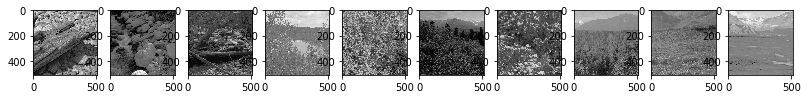

Filters after 0 epochs


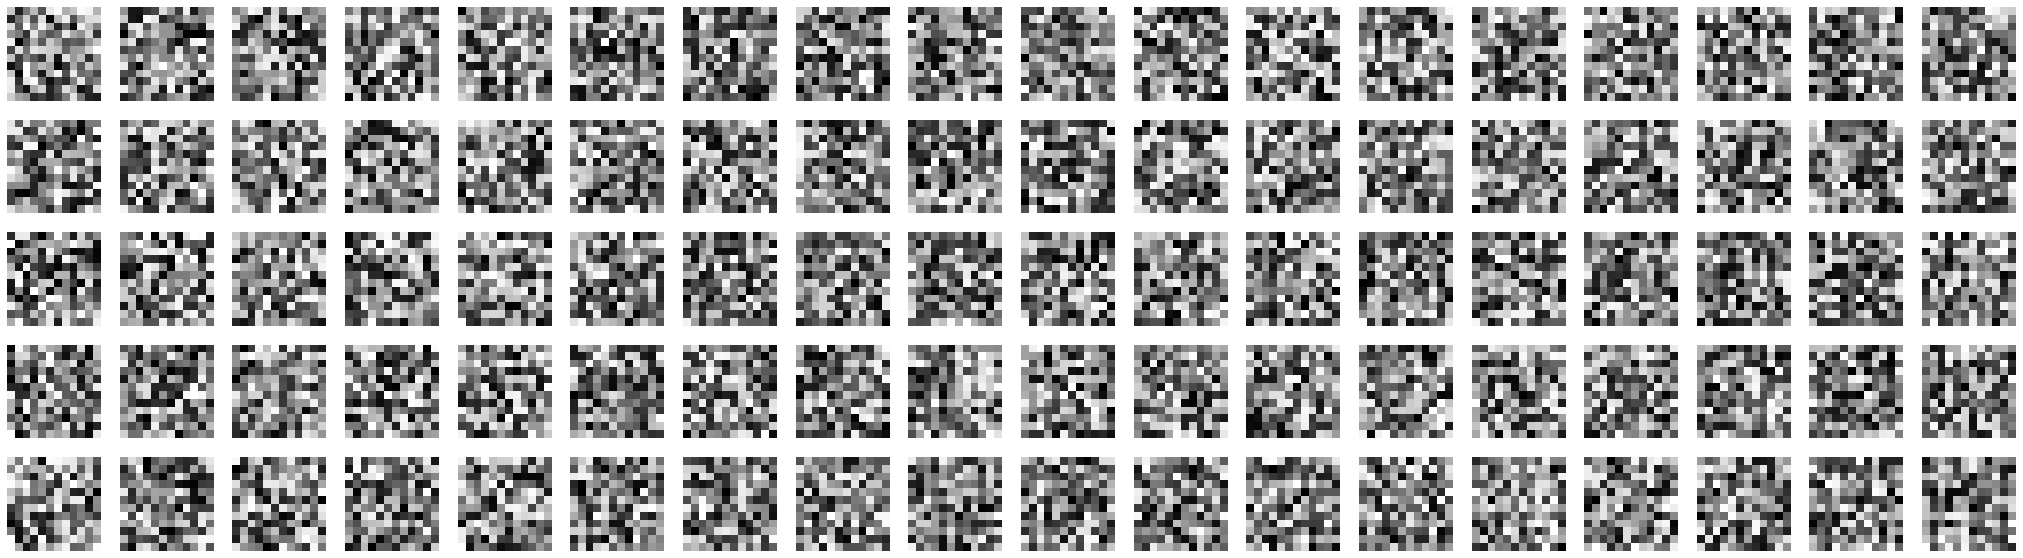

Filters after 1000 epochs


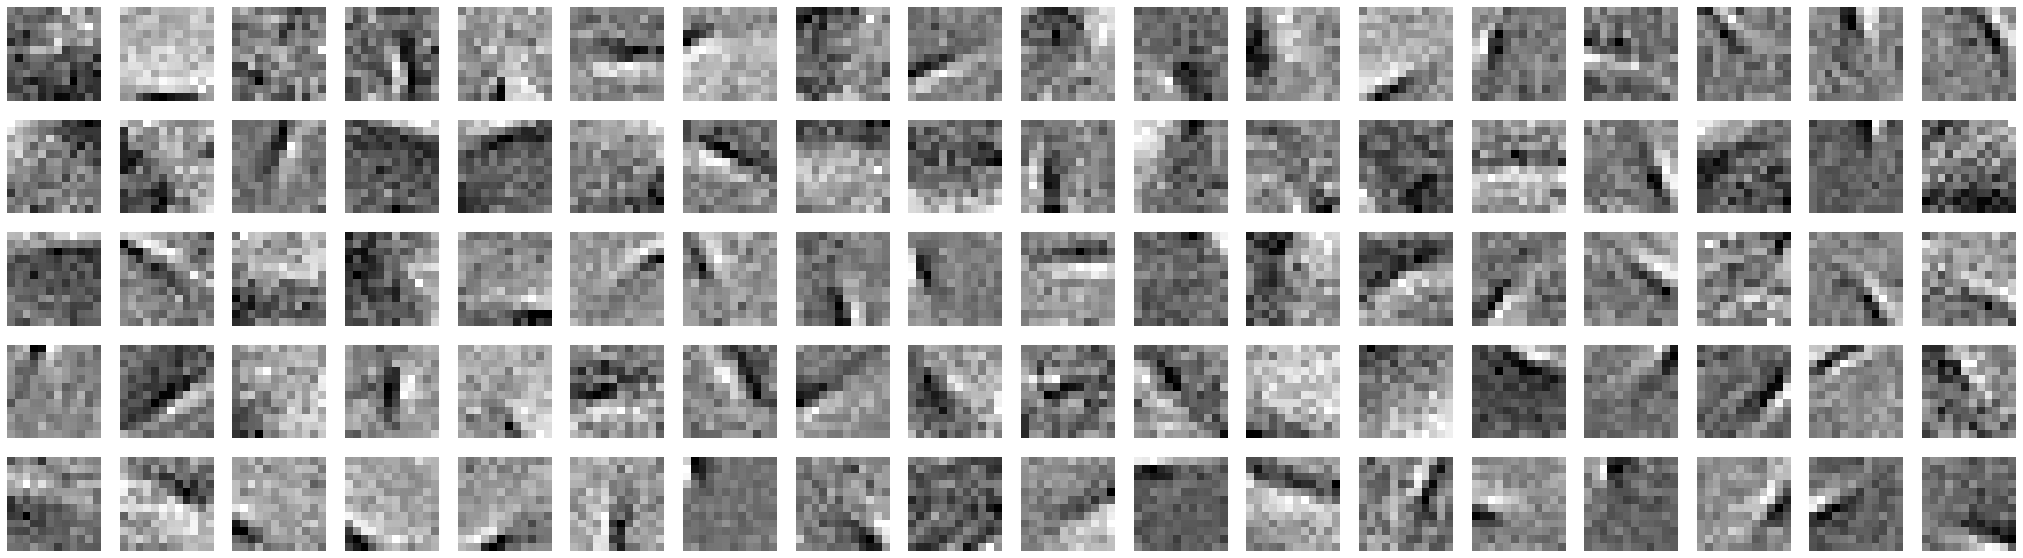

Filters after 2000 epochs


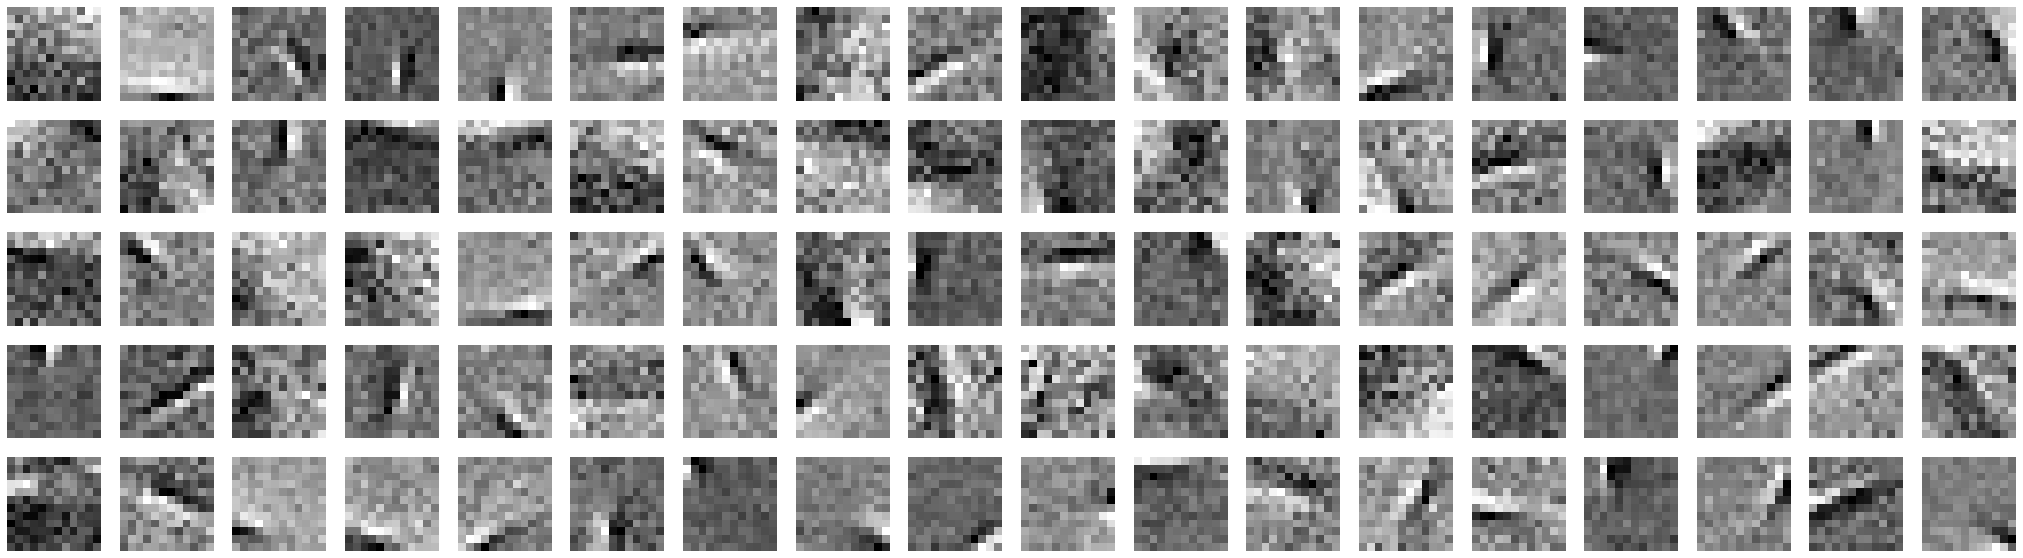

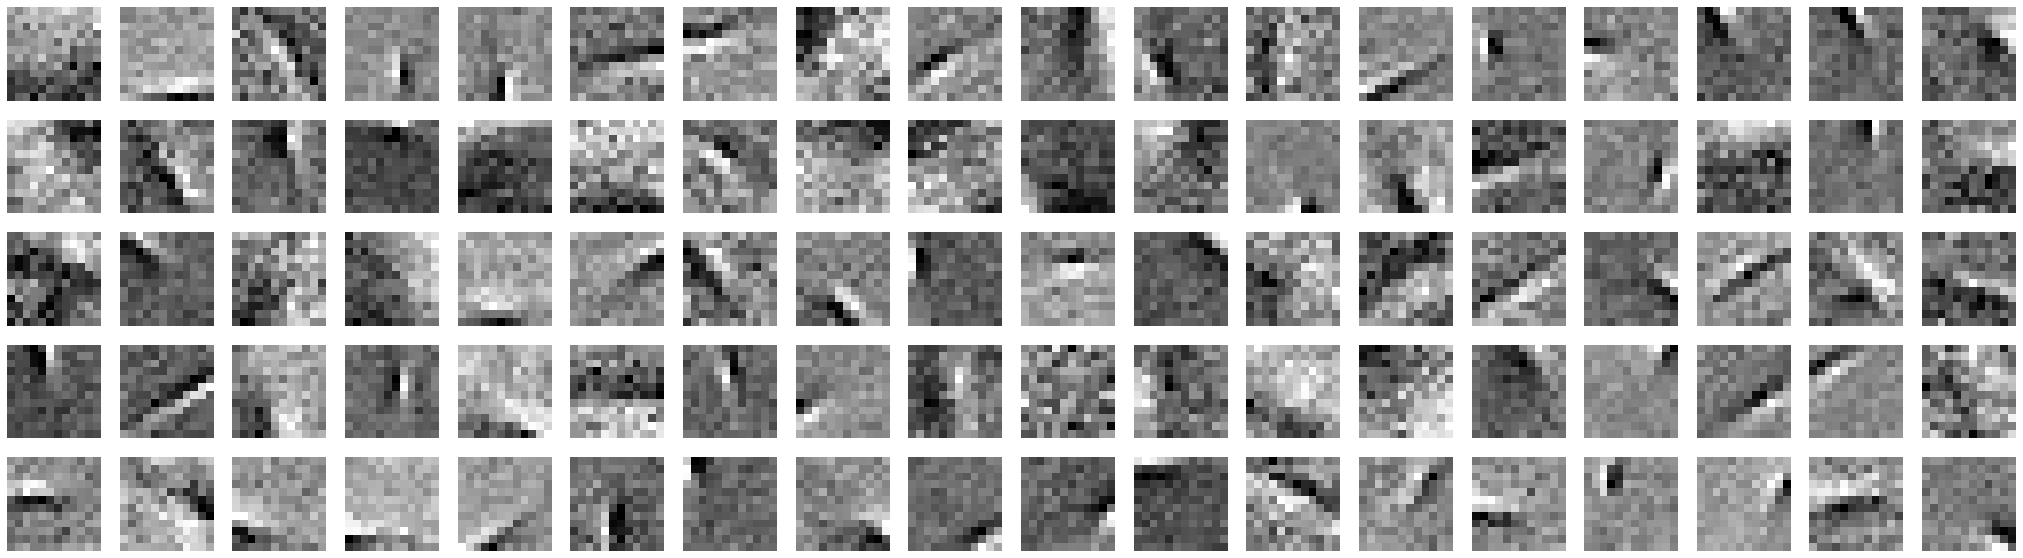

Magnitude of learning gradients through iterations


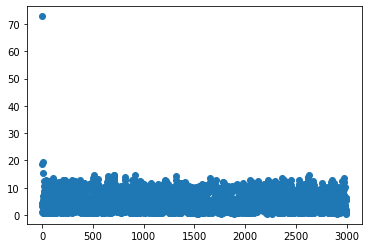

Trying to reconstruct images using our dictionary: original patches displayed, then reconstructions afterwards


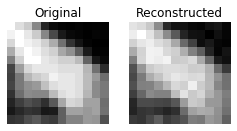

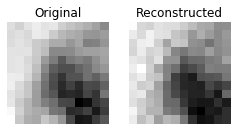

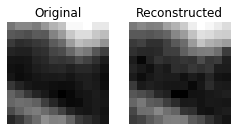

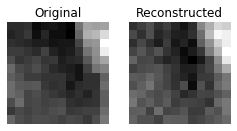

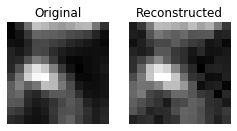

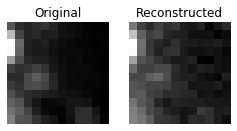

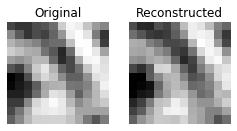

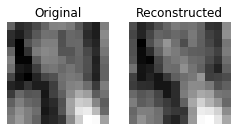

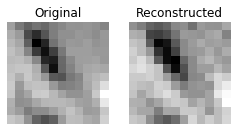

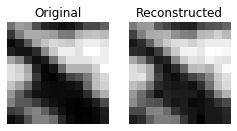

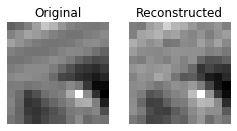

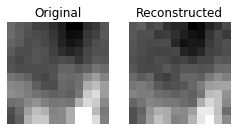

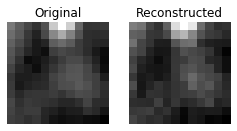

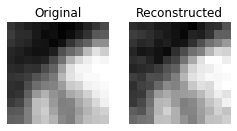

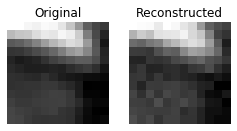

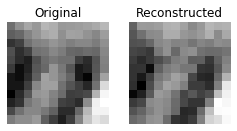

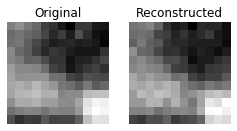

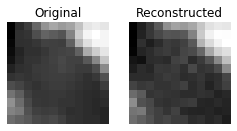

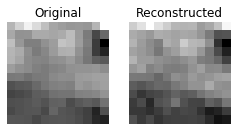

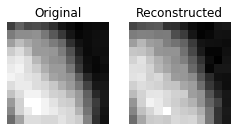

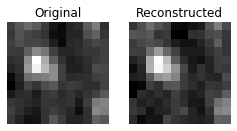

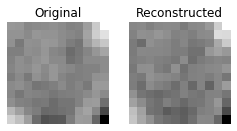

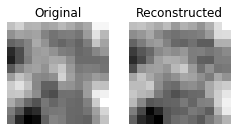

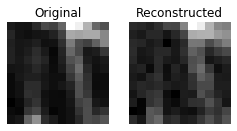

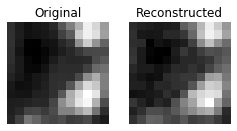

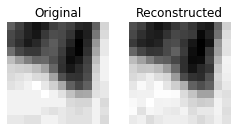

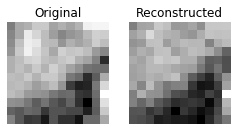

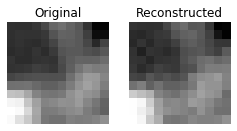

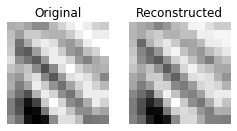

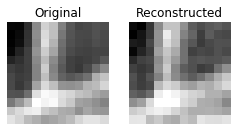

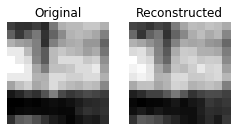

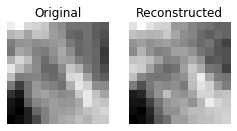

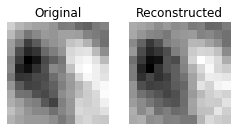

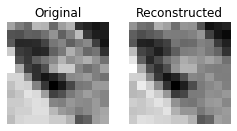

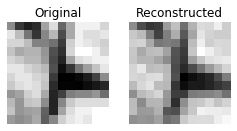

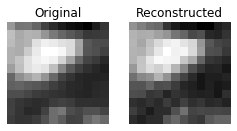

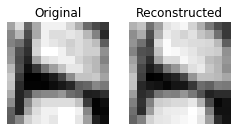

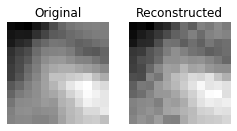

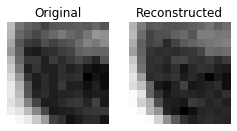

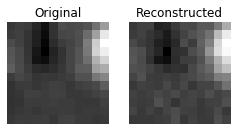

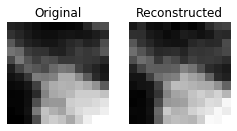

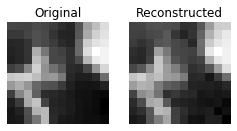

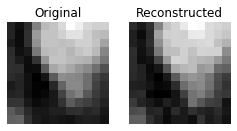

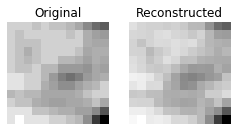

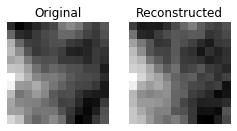

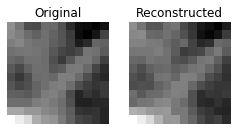

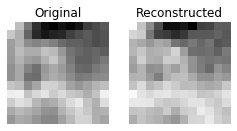

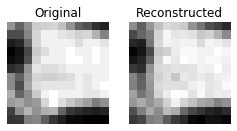

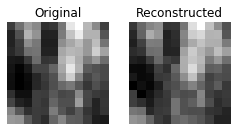

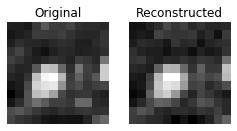

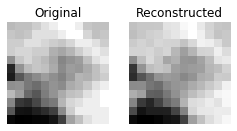

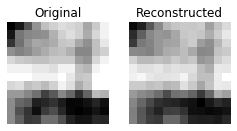

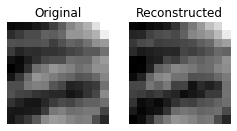

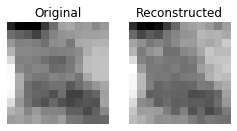

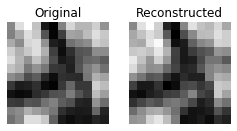

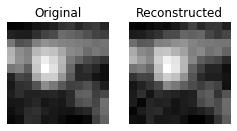

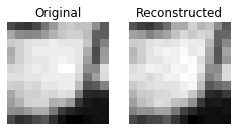

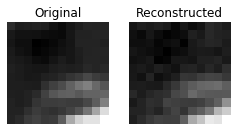

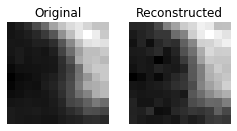

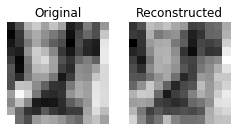

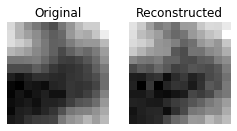

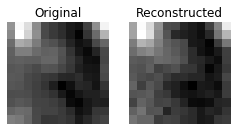

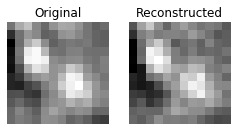

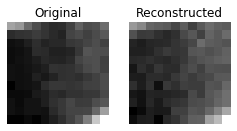

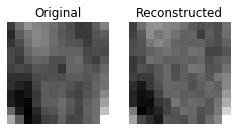

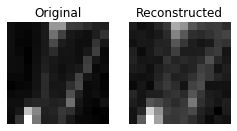

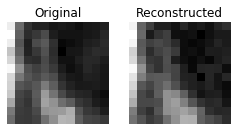

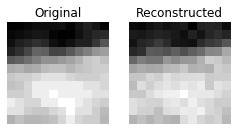

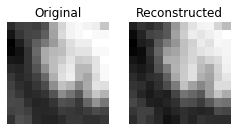

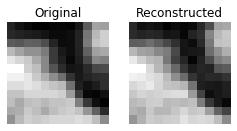

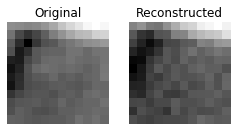

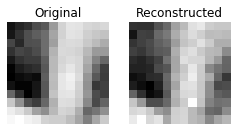

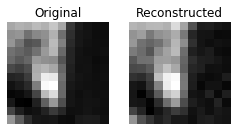

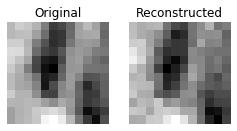

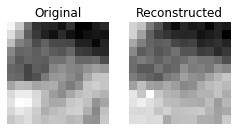

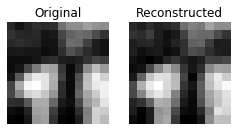

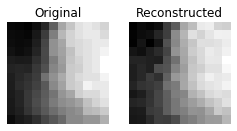

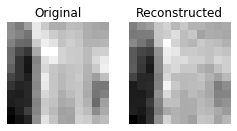

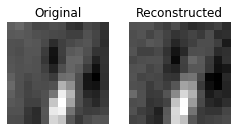

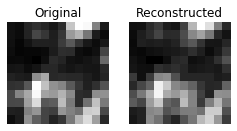

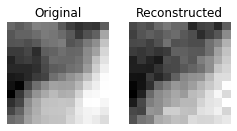

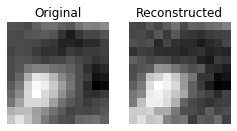

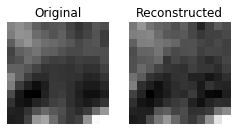

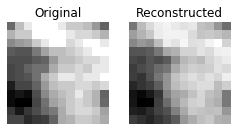

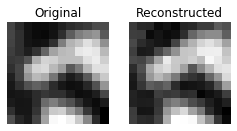

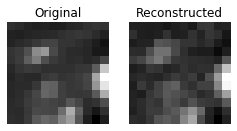

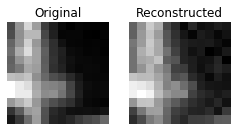

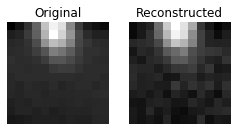

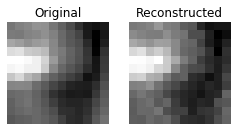

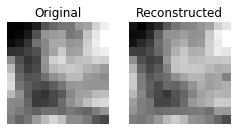

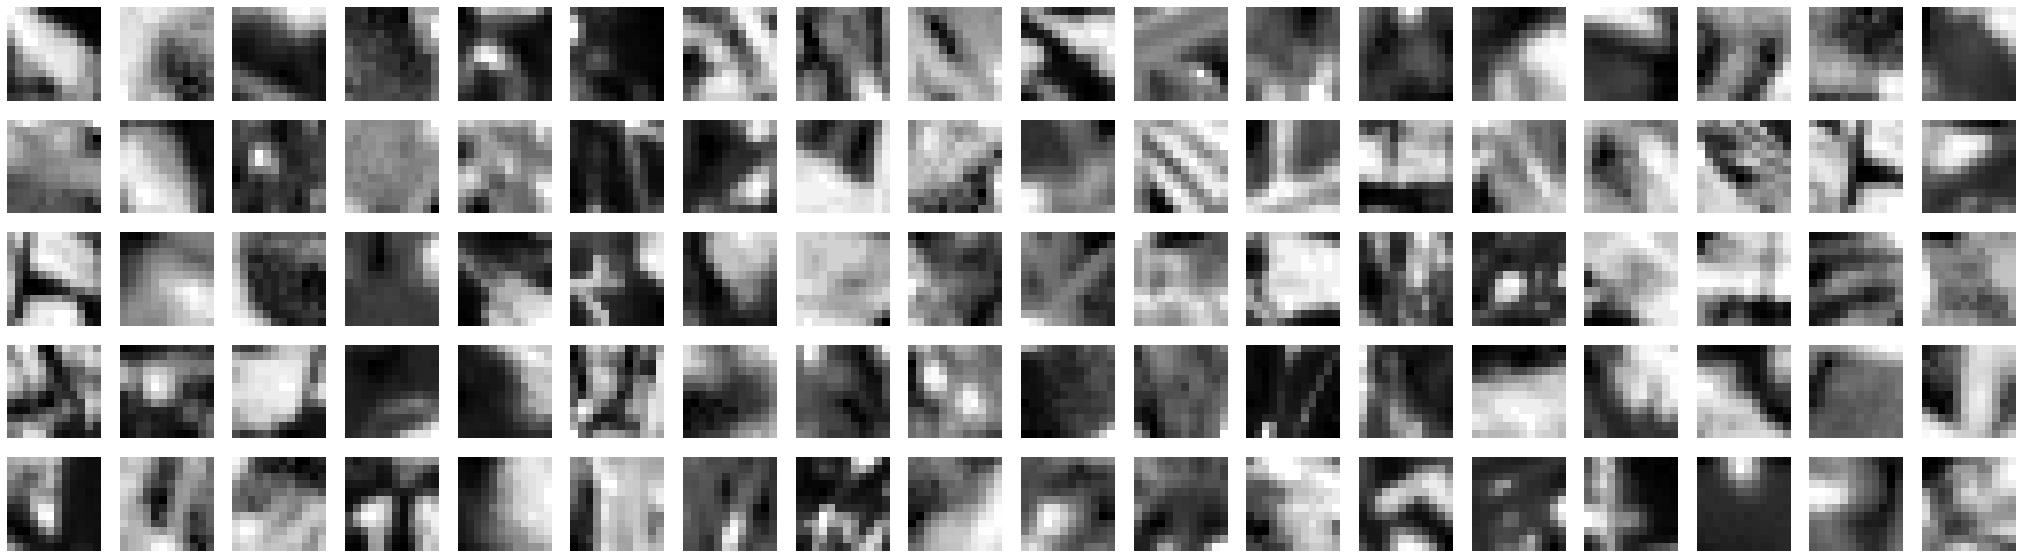

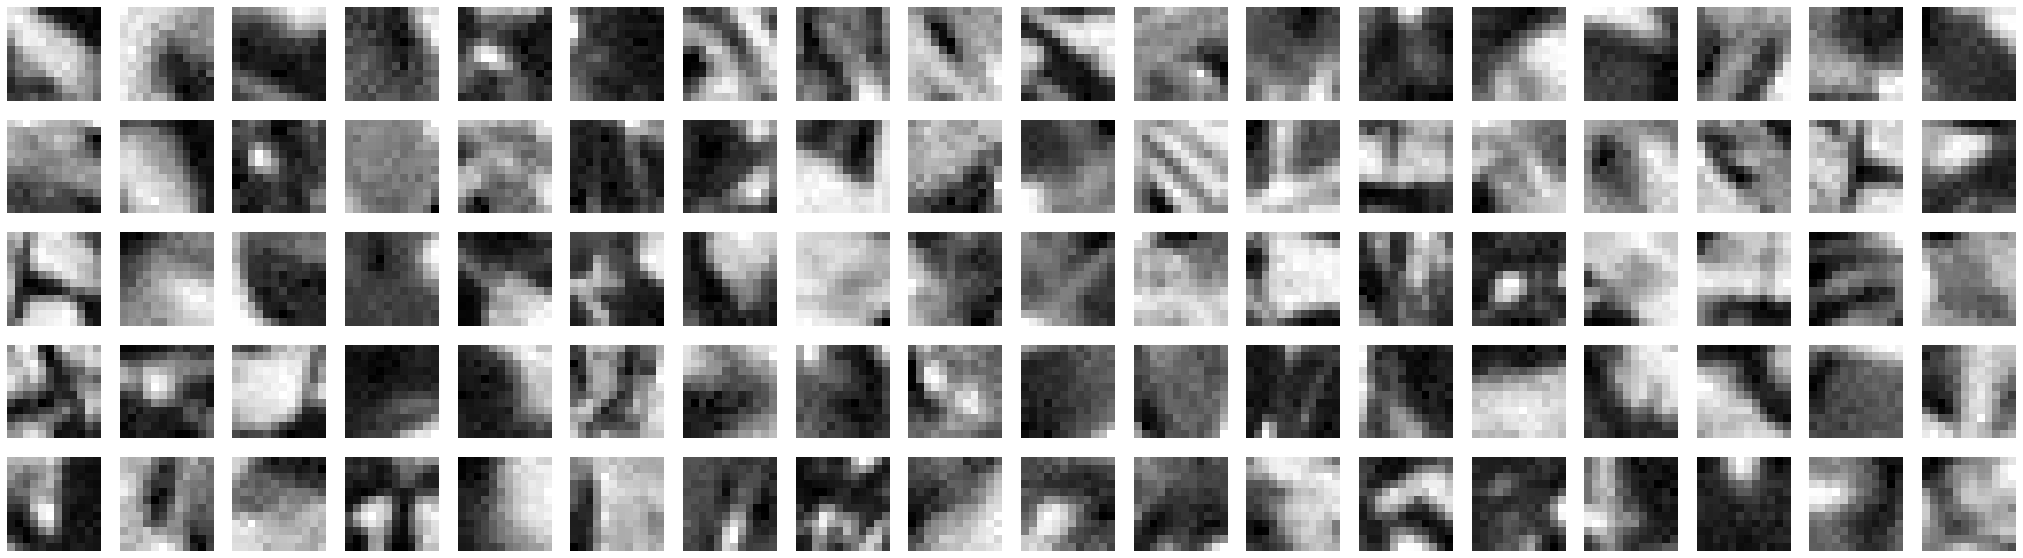

In [11]:
import scipy.io
%matplotlib inline
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn import linear_model
# import time
from tqdm.notebook import tqdm

BATCH_SIZE = 90
NUM_FILTERS = 220
FILTER_WIDTH = 12

"""
I/O utility functions
"""

def read_inputs():
    data = scipy.io.loadmat("datasets/IMAGES_RAW.mat")
    images = data["IMAGESr"]
    # images is a 3D array of size [512,512,10], 10 images of size 512 x 512
    num_images = len(images[0,0])
    # Show the images.
    print("Our training dataset consists of these 10 images:")
    plt.figure(figsize=(15,5))
    for i in range(num_images):
        plt.subplot(1, num_images+1, i+1)
        plt.imshow(images[:,:,i], cmap="gray")
    plt.show()
    
    return images, num_images

def plot_digits(in_data, nrows=5, ncols=18, titles=None): 
    plt.figure(figsize=(ncols*2, nrows*2))
    for i in range(min(nrows*ncols, len(in_data))): 
        if titles:
            plt.subplot(nrows, ncols, i+1, title=titles[i]) 
        else:
            plt.subplot(nrows, ncols, i+1) 
        plt.imshow(in_data[i].reshape((FILTER_WIDTH,FILTER_WIDTH)), cmap="gray")
        plt.axis("off")
    plt.show()

"""
Image manipulation
"""

# Function to sample `BATCH_SIZE` square image patches from a single large `image`.
def sample_random_patches(image):
    patches = np.zeros([FILTER_WIDTH, FILTER_WIDTH, BATCH_SIZE]);
    for k in range(BATCH_SIZE):
        i, j = random.sample(range(image.shape[0]-FILTER_WIDTH), 2)
        patches[:,:,k] = image[i:i+FILTER_WIDTH,j:j+FILTER_WIDTH]
    return patches

def patches_minibatch(num_images, images):
    random_image_index = int(num_images * np.random.rand())
    image = images[:,:,random_image_index]
    patches = sample_random_patches(image)
    for _ in range(num_images - 1):
        random_image_index = int(num_images * np.random.rand())
        image = images[:,:,random_image_index]
        patches = np.concatenate((sample_random_patches(image), patches), axis=2)
    patches = np.array([patches[:,:,k].flatten() for k in range(BATCH_SIZE)])
    return patches

"""
Machine Learning and Optimization
"""

# nb normalizes ROWS, because:
# iteration through a numpy matrix gives you rows (numpy is weird)
normalize = lambda x: np.array([y/np.linalg.norm(y) for y in x])

# `filters` are the dictionary we are building
def sgd_optimize(filters, patches, clf, sgd_rate = .04): #, steps = 0):
    # if steps > 100:
    #    sgd_rate *= (steps)**(-.5)

    reconstructions = clf.predict(filters) # np.dot(filters, coefficients)
    gradient = np.dot(reconstructions - patches, clf.coef_)
    filters -= sgd_rate * gradient
    filters = normalize(filters.T).T
    
    return filters, gradient, reconstructions

def learn_filters(clf, num_images, images):
    filters = np.random.rand(NUM_FILTERS, FILTER_WIDTH**2)

    grads = []
    niter = 3000
    for i in tqdm(range(niter)):
        if i % 1000 == 0:
            print("Filters after", i, "epochs")
            plot_digits(filters)

        # New minibatch
        patches = patches_minibatch(num_images, images)
        
        # Want columns to be images, not rows
        patches = patches.T
        filters = filters.T

        clf.fit(filters, patches)
        # Optimize alpha wrt filters dictionary
        filters, gradient, reconstructions = sgd_optimize(filters, patches, clf) # , steps=0) # v=i)
        grads.append(np.linalg.norm(gradient)/np.linalg.norm(filters))

        patches = patches.T
        filters = filters.T
    
    plot_digits(filters)
    # Monitor the convergence of the SGD algorithm by checking the change in the code- book. 
    print("Magnitude of learning gradients through iterations")
    plt.scatter(np.arange(0, niter), grads)
    plt.show()
    return filters

def main():
    images, num_images = read_inputs()

    # Use the class sklearn.linear_model.Lasso for the coefficient estimation step.
    clf = linear_model.Lasso(alpha=0.001, max_iter=6000, fit_intercept=True)
    filters = learn_filters(clf, num_images, images)
    patches = patches_minibatch(num_images, images)
    clf.fit(filters.T, patches.T)
    reconstructions = clf.predict(filters.T).T

    print("Trying to reconstruct images using our dictionary: original patches displayed, then reconstructions afterwards")
    
    for patch, reconstruction in zip(patches, reconstructions):
        plot_digits([patch, reconstruction], nrows=1, ncols=2, titles=["Original","Reconstructed"])
        
    plot_digits(patches)
    plot_digits(reconstructions)

main()